Importação da etapa de pré-processamento

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../STab'))

In [2]:
from pre_processing import ChurnDataProcessor
from STab import MainModel, Num_Cat

Importação das bibliotecas necessárias

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from scipy.stats import ks_2samp
import keras4torch
from keras4torch.callbacks import EarlyStopping, ModelCheckpoint

c:\Users\pe006118\PrevisaoChurn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Configuração de semente para reprodutibilidade
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
file_path = os.path.abspath('../../data/customer_churn_telecom_services.csv')
processor = ChurnDataProcessor(file_path)
processor.split_and_balance() # realizar apenas a divisão dos dados, porque vamos usar técnicas de tratamento diferentes para o STab

In [6]:
#Log de verificação dos dados
print(f"Dados carregados e divididos.")
print(f"Treino: {processor.train_df.shape}")
print(f"Validação: {processor.validation_df.shape}")
print(f"Teste: {processor.test_df.shape}")

Dados carregados e divididos.
Treino: (5174, 20)
Validação: (2586, 20)
Teste: (1761, 20)


In [7]:
def prepare_data_for_stab(processor):
    """
    Prepara os dados do processor para o formato específico do STab:
    - Numéricas: StandardScaler
    - Categóricas: LabelEncoder (Inteiros)
    - Retorno: Listas [X_num, X_cat] compatíveis com Num_Cat
    """
    # Cópias para não alterar o original
    train_df = processor.train_df.copy()
    val_df = processor.validation_df.copy()
    test_df = processor.test_df.copy()

    # Tratamento de Nulos
    for df in [train_df, val_df, test_df]:
        df['TotalCharges'] = df['TotalCharges'].fillna(0.0)

    # Definição de Colunas
    target_col = 'Churn'
    num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    # Todas as outras colunas (exceto target e numéricas) são categóricas
    cat_cols = [c for c in train_df.columns if c not in num_cols + [target_col]]

    # 1. Processamento Numérico (StandardScaler)
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(train_df[num_cols]).astype(np.float32)
    X_val_num = scaler.transform(val_df[num_cols]).astype(np.float32)
    X_test_num = scaler.transform(test_df[num_cols]).astype(np.float32)

    # 2. Processamento Categórico (LabelEncoder)
    cat_cardinalities = []
    
    # Matrizes para guardar os índices inteiros
    X_train_cat = np.zeros((len(train_df), len(cat_cols)), dtype=np.int64)
    X_val_cat = np.zeros((len(val_df), len(cat_cols)), dtype=np.int64)
    X_test_cat = np.zeros((len(test_df), len(cat_cols)), dtype=np.int64)

    for i, col in enumerate(cat_cols):
        le = LabelEncoder()
        # Treina com todos os dados possíveis para não dar erro de categoria desconhecida
        all_data = pd.concat([train_df[col], val_df[col], test_df[col]])
        le.fit(all_data.astype(str))
        
        X_train_cat[:, i] = le.transform(train_df[col].astype(str))
        X_val_cat[:, i] = le.transform(val_df[col].astype(str))
        X_test_cat[:, i] = le.transform(test_df[col].astype(str))
        
        # Guarda a cardinalidade (+1 para segurança)
        cat_cardinalities.append(len(le.classes_) + 1)

    # 3. Targets
    le_target = LabelEncoder()
    y_train = torch.tensor(le_target.fit_transform(train_df[target_col]), dtype=torch.long)
    y_val = torch.tensor(le_target.transform(val_df[target_col]), dtype=torch.long)
    y_test = torch.tensor(le_target.transform(test_df[target_col]), dtype=torch.long)

    return (
        [X_train_num, X_train_cat], y_train,
        [X_val_num, X_val_cat], y_val,
        [X_test_num, X_test_cat], y_test,
        cat_cardinalities,
        len(num_cols)
    )

# Executa a preparação
X_train, y_train, X_val, y_val, X_test, y_test, categories_list, num_continuous = prepare_data_for_stab(processor)

print(f"Dados transformados para STab.")
print(f"Cardinalidades das categorias: {categories_list}")

Dados transformados para STab.
Cardinalidades das categorias: [3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5]


In [8]:
def objective(trial):
    # --- Espaço de Busca ---
    params = {
        'dim': trial.suggest_categorical('dim', [8, 16, 32, 64]),
        'depth': trial.suggest_int('depth', 1, 6),
        'heads': trial.suggest_categorical('heads', [2, 4, 8]),
        'attn_dropout': trial.suggest_float('attn_dropout', 0.0, 0.5),
        'ff_dropout': trial.suggest_float('ff_dropout', 0.0, 0.5),
        'U': trial.suggest_int('U', 1, 4), 
        'cases': trial.suggest_categorical('cases', [8, 16]),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
    }

    # Instanciando o Modelo Base (MainModel)
    base_model = MainModel(
        categories=tuple(categories_list),
        num_continuous=num_continuous,
        dim=params['dim'],
        dim_out=2, # Binário
        depth=params['depth'],
        heads=params['heads'],
        attn_dropout=params['attn_dropout'],
        ff_dropout=params['ff_dropout'],
        U=params['U'],
        cases=params['cases']
    )

    # Wrapper para Keras4Torch (Num_Cat)
    full_model = Num_Cat(base_model, num_number=num_continuous, classes=2, Sample_size=params['dim'])
    
    # Construção do Modelo
    model = keras4torch.Model(full_model).build([num_continuous, len(categories_list)])
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    
    model.compile(optimizer=optimizer, loss=F.cross_entropy, metrics=['accuracy'])

    # Critério de Parada (Patience=20 conforme PDF)
    es = EarlyStopping(monitor='val_loss', patience=20)
    
    # Treinamento (verbose=0 para não poluir o output)
    history = model.fit(
        X_train, y_train,
        epochs=200, # Limite seguro para o Optuna
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[es],
        verbose=0 
    )
    
    # Retorna o melhor loss de validação
    return es.best_score

In [ ]:
print("--- Iniciando Otimização de Hiperparâmetros (Optuna) ---")
# Cria o estudo para MINIMIZAR a perda (loss)
study = optuna.create_study(direction='minimize')

# Executa 20 tentativas (trials) - Ajuste se tiver tempo/GPU sobrando
study.optimize(objective, n_trials=20)

print("\n--- Otimização Concluída ---")
print("Melhores Hiperparâmetros encontrados:")
print(study.best_params)

[I 2025-12-05 08:51:14,705] A new study created in memory with name: no-name-1b7d6261-bc2f-469d-957a-4e53ec1718f7


--- Iniciando Otimização de Hiperparâmetros (Optuna) ---


[I 2025-12-05 10:13:43,675] Trial 0 finished with value: 0.6931486138058373 and parameters: {'dim': 8, 'depth': 6, 'heads': 4, 'attn_dropout': 0.2976077261676695, 'ff_dropout': 0.40777466670903156, 'U': 4, 'cases': 8, 'lr': 0.009926859198113794, 'weight_decay': 0.0006415561531192072, 'batch_size': 32}. Best is trial 0 with value: 0.6931486138058373.


[INFO] Early Stopped. The best score is 0.6931.


[I 2025-12-05 10:38:56,962] Trial 1 finished with value: 0.5007828581913994 and parameters: {'dim': 32, 'depth': 4, 'heads': 8, 'attn_dropout': 0.486935580943921, 'ff_dropout': 0.41035068754774306, 'U': 4, 'cases': 16, 'lr': 0.00011799102545834225, 'weight_decay': 3.147890013752703e-05, 'batch_size': 64}. Best is trial 1 with value: 0.5007828581913994.


[INFO] Early Stopped. The best score is 0.5008.


[I 2025-12-05 10:51:28,818] Trial 2 finished with value: 0.49771823469558063 and parameters: {'dim': 8, 'depth': 6, 'heads': 4, 'attn_dropout': 0.28691865497649705, 'ff_dropout': 0.03825033623562091, 'U': 2, 'cases': 16, 'lr': 0.003488791157303748, 'weight_decay': 0.0006367394805584898, 'batch_size': 64}. Best is trial 2 with value: 0.49771823469558063.


[INFO] Early Stopped. The best score is 0.4977.


[I 2025-12-05 10:56:13,252] Trial 3 finished with value: 0.5007910163063276 and parameters: {'dim': 8, 'depth': 2, 'heads': 4, 'attn_dropout': 0.054661268592364864, 'ff_dropout': 0.3531049108404192, 'U': 4, 'cases': 16, 'lr': 0.00031967750708265796, 'weight_decay': 8.311128090465676e-05, 'batch_size': 128}. Best is trial 2 with value: 0.49771823469558063.


[INFO] Early Stopped. The best score is 0.5008.


[I 2025-12-05 10:59:25,434] Trial 4 finished with value: 0.5034292157730758 and parameters: {'dim': 64, 'depth': 2, 'heads': 8, 'attn_dropout': 0.0028379626119942603, 'ff_dropout': 0.3545136534213119, 'U': 3, 'cases': 8, 'lr': 0.0009662495000244783, 'weight_decay': 6.634229637957923e-05, 'batch_size': 64}. Best is trial 2 with value: 0.49771823469558063.


[INFO] Early Stopped. The best score is 0.5034.


[I 2025-12-05 11:07:00,090] Trial 5 finished with value: 0.4972853478727097 and parameters: {'dim': 16, 'depth': 3, 'heads': 2, 'attn_dropout': 0.21283456599072464, 'ff_dropout': 0.21820012524619686, 'U': 1, 'cases': 16, 'lr': 0.00016846059951540875, 'weight_decay': 0.0002788563157139054, 'batch_size': 64}. Best is trial 5 with value: 0.4972853478727097.


[INFO] Early Stopped. The best score is 0.4973.


[I 2025-12-05 11:17:50,500] Trial 6 finished with value: 0.49993862226686087 and parameters: {'dim': 64, 'depth': 6, 'heads': 4, 'attn_dropout': 0.16350202021594118, 'ff_dropout': 0.32867060313180857, 'U': 1, 'cases': 8, 'lr': 0.0012454994889573214, 'weight_decay': 0.0003303260612038617, 'batch_size': 64}. Best is trial 5 with value: 0.4972853478727097.


[INFO] Early Stopped. The best score is 0.4999.


[I 2025-12-05 11:23:54,369] Trial 7 finished with value: 0.5070140637451609 and parameters: {'dim': 32, 'depth': 5, 'heads': 4, 'attn_dropout': 0.0281728718991221, 'ff_dropout': 0.01204898378898428, 'U': 3, 'cases': 16, 'lr': 0.00027743752526271094, 'weight_decay': 4.762612528578367e-05, 'batch_size': 32}. Best is trial 5 with value: 0.4972853478727097.


[INFO] Early Stopped. The best score is 0.5070.


[I 2025-12-05 11:33:19,395] Trial 8 finished with value: 0.504003852352281 and parameters: {'dim': 64, 'depth': 5, 'heads': 4, 'attn_dropout': 0.2299393376682129, 'ff_dropout': 0.16188448751585066, 'U': 1, 'cases': 8, 'lr': 0.00045189664335519016, 'weight_decay': 0.0007246552801259119, 'batch_size': 64}. Best is trial 5 with value: 0.4972853478727097.


[INFO] Early Stopped. The best score is 0.5040.


[I 2025-12-05 11:38:40,111] Trial 9 finished with value: 0.5172957153810794 and parameters: {'dim': 8, 'depth': 3, 'heads': 4, 'attn_dropout': 0.2970364547348502, 'ff_dropout': 0.2914750337040345, 'U': 1, 'cases': 16, 'lr': 0.006024399439278988, 'weight_decay': 2.8669491198947842e-05, 'batch_size': 32}. Best is trial 5 with value: 0.4972853478727097.


[INFO] Early Stopped. The best score is 0.5173.


In [ ]:
best_p = study.best_params

print(f"Treinando modelo final com: {best_p}")

# Recria a arquitetura com os melhores parâmetros
final_base = MainModel(
    categories=tuple(categories_list),
    num_continuous=num_continuous,
    dim=best_p['dim'],
    dim_out=2,
    depth=best_p['depth'],
    heads=best_p['heads'],
    attn_dropout=best_p['attn_dropout'],
    ff_dropout=best_p['ff_dropout'],
    U=best_p['U'],
    cases=best_p['cases']
)

final_wrapper = Num_Cat(final_base, num_number=num_continuous, classes=2, Sample_size=best_p['dim'])
final_model = keras4torch.Model(final_wrapper).build([num_continuous, len(categories_list)])

optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_p['lr'], weight_decay=best_p['weight_decay'])
final_model.compile(optimizer=optimizer, loss=F.cross_entropy, metrics=['accuracy'])

# Callbacks para o modelo final
# Salva o melhor modelo da história do treinamento
cp = ModelCheckpoint('best_stab_model.pt', monitor='val_loss', save_best_only=True)
es_final = EarlyStopping(monitor='val_loss', patience=20)

history = final_model.fit(
    X_train, y_train,
    epochs=500, # Mais épocas para o modelo final
    batch_size=best_p['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[es_final, cp],
    verbose=1
)

# Carrega os pesos da melhor época
final_model.load_weights('best_stab_model.pt')
print("Melhor modelo carregado.")

Treinando modelo final com: {'dim': 8, 'depth': 1, 'heads': 4, 'attn_dropout': 0.15925019467223908, 'ff_dropout': 0.1302515183196202, 'U': 3, 'cases': 8, 'lr': 0.0018741827457969555, 'weight_decay': 3.063645751506513e-05, 'batch_size': 128}
Train on 5174 samples, validate on 2586 samples:
Epoch 1/500
41/41 - 0.9s - loss: 0.7136 - acc: 0.5000 - val_loss: 0.7032 - val_acc: 0.5000 - lr: 1.9e-03
Epoch 2/500
41/41 - 1.2s - loss: 0.7001 - acc: 0.5000 - val_loss: 0.6972 - val_acc: 0.5000 - lr: 1.9e-03
Epoch 3/500
41/41 - 1.1s - loss: 0.6959 - acc: 0.5000 - val_loss: 0.6946 - val_acc: 0.5000 - lr: 1.9e-03
Epoch 4/500
41/41 - 1.1s - loss: 0.6941 - acc: 0.5000 - val_loss: 0.6936 - val_acc: 0.5000 - lr: 1.9e-03
Epoch 5/500
41/41 - 1.1s - loss: 0.6934 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5000 - lr: 1.9e-03
Epoch 6/500
41/41 - 1.6s - loss: 0.6931 - acc: 0.5039 - val_loss: 0.6920 - val_acc: 0.5352 - lr: 1.9e-03
Epoch 7/500
41/41 - 1.0s - loss: 0.6807 - acc: 0.5630 - val_loss: 0.6283 - val_a


=== Relatório de Classificação (Teste) ===
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1294
           1       0.56      0.80      0.66       467

    accuracy                           0.78      1761
   macro avg       0.74      0.79      0.75      1761
weighted avg       0.82      0.78      0.79      1761


=== Métrica KS (Kolmogorov-Smirnov) ===
KS Statistic: 0.5875
P-value: 5.5825806369352216e-111
>> Resultado: BOM/MUITO BOM (KS > 0.4)


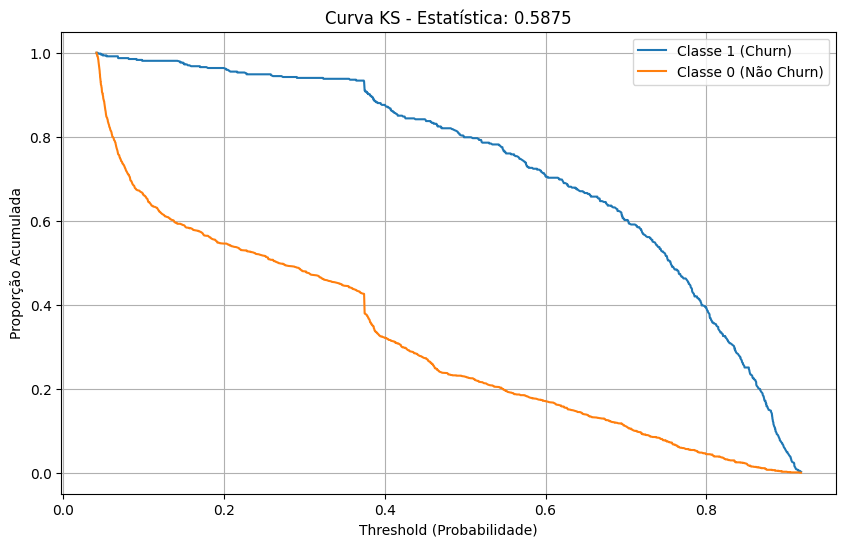

: 

In [ ]:
# --- Predições no Conjunto de Teste ---
logits = final_model.predict(X_test)
# Aplica Softmax para ter probabilidades
probs = F.softmax(torch.tensor(logits), dim=1).numpy()
y_pred_class = np.argmax(probs, axis=1)
y_prob_churn = probs[:, 1] # Probabilidade da classe 1 (Churn)

# 1. Relatório de Classificação
print("\n=== Relatório de Classificação (Teste) ===")
print(classification_report(y_test.numpy(), y_pred_class))

# 2. Cálculo do KS (Kolmogorov-Smirnov) - MÉTRICA PRINCIPAL
class_0_probs = y_prob_churn[y_test.numpy() == 0]
class_1_probs = y_prob_churn[y_test.numpy() == 1]
ks_stat, p_val = ks_2samp(class_0_probs, class_1_probs)

print(f"\n=== Métrica KS (Kolmogorov-Smirnov) ===")
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-value: {p_val}")

if ks_stat > 0.4:
    print(">> Resultado: BOM/MUITO BOM (KS > 0.4)")
else:
    print(">> Resultado: REGULAR (KS < 0.4)")

# 3. Gráfico da Curva KS (Opcional, mas recomendado no PDF)
def plot_ks_curve(y_true, y_probs):
    plt.figure(figsize=(10, 6))
    # Ordena probabilidades
    thresholds = np.sort(y_probs)
    
    # Calcula CDFs empíricas
    tpr = [] # True Positive Rate (acumulado classe 1)
    fpr = [] # False Positive Rate (acumulado classe 0)
    
    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos
    
    # Truque rápido para plotar KS
    for th in thresholds:
        tp = np.sum((y_probs >= th) & (y_true == 1))
        fp = np.sum((y_probs >= th) & (y_true == 0))
        tpr.append(tp / n_pos)
        fpr.append(fp / n_neg)
        
    plt.plot(thresholds, tpr, label='Classe 1 (Churn)')
    plt.plot(thresholds, fpr, label='Classe 0 (Não Churn)')
    plt.title(f'Curva KS - Estatística: {ks_stat:.4f}')
    plt.xlabel('Threshold (Probabilidade)')
    plt.ylabel('Proporção Acumulada')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_ks_curve(y_test.numpy(), y_prob_churn)

In [ ]:
df_trials = study.trials_dataframe()
df_trials_sorted = df_trials.sort_values("value").head(10)
print("Top 10 trials do Optuna:")
df_trials_sorted